In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
csv_path  = "M2_2.18mM_pressure_o2_release.csv"
time_col  = "Time (s)"                     # your column is actually hours
press_col = "DWT denoised pressure (kPa)"  # pressure in kPa
gas_col   = "O2 Released (µmol)"          # headspace O2 from csv

In [22]:
df = pd.read_csv(csv_path)
df.columns = [c.strip() for c in df.columns]

# Plotting naq and pressure directly in multiple units (kpa and atm)

certain parts of the code must be uncomennted to plot the different graphs


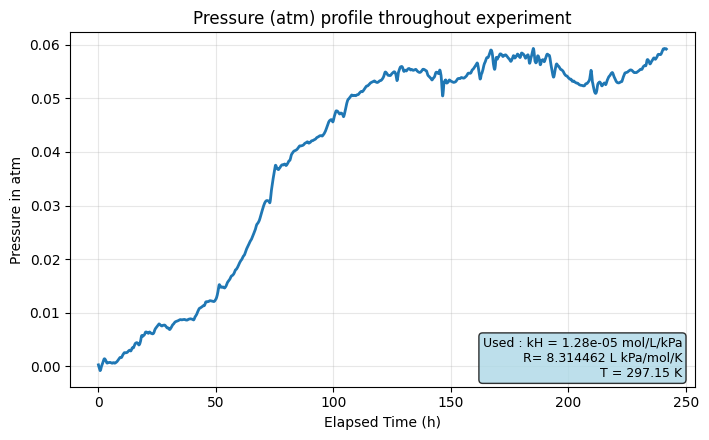

In [7]:
time_h     = pd.to_numeric(df[time_col])
p_kpa      = pd.to_numeric(df[press_col])
n_gas_umol = pd.to_numeric(df[gas_col])


n_theory  = 13.08                         # µmol (theoretical)
kH = 1.283e-5           # mol/L/kPa
Vsol = 0.006           # L
Vg = 0.002
R = 8.314462           # L kPa/mol/K
T = 297.15             # K


def n_aq_umol_from_kpa(p_kpa: pd.Series) -> pd.Series:
    
    n_aq_umol = p_kpa * Vsol * kH * 1e6
    return n_aq_umol

def plotting_pressure(p_kpa: pd.Series) -> pd.Series:

    pressure_plot = p_kpa
    return pressure_plot

def plotting_pressure_in_atm(p_kpa: pd.Series) -> pd.Series:
    pressure_atm = p_kpa / 101.325
    return pressure_atm


#n_aq_umol = n_aq_umol_from_kpa(p_kpa)
# pressure_plot = plotting_pressure(p_kpa)
pressure_atm_plot = plotting_pressure_in_atm(p_kpa)
df_out = pd.DataFrame({
    "Elapsed Time (h)": time_h,
    # "n_aq (µmol)": n_aq_umol,
    "p_kpa (kPa)": p_kpa,
    "p_atm (atm)": pressure_atm_plot
})

plt.figure(figsize=(7.2, 4.5))



plt.plot(df_out["Elapsed Time (h)"], df_out["p_atm (atm)"], linewidth=2)
plt.ylabel("Pressure in atm")
plt.xlabel("Elapsed Time (h)")
plt.title("Pressure (atm) profile throughout experiment")





# plt.plot(df_out["Elapsed Time (h)"], df_out["p_kpa (kPa)"], linewidth=2)
# plt.ylabel("Pressure in kPa")
# plt.xlabel("Elapsed Time (h)")
# plt.title("Pressure (kPa) profile throughout experiment")



# plt.plot(df_out["Elapsed Time (h)"], df_out["n_aq (µmol)"], linewidth=2)
# plt.ylabel("Dissolved oxygen n_aq in µmol")
# plt.xlabel("Elapsed Time (h)")
# plt.title("Dissolved Oxygen (n_aq) calculated from Pressure (kPa)")






# Add detailed info box
info_text = f"""Used : kH = {kH:.2e} mol/L/kPa
R= {R} L kPa/mol/K
T = {T} K"""

plt.text(0.98, 0.02, info_text, 
         transform=plt.gca().transAxes,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=9,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))



plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Using the equation directly to plot graph (in atm)
""" Units used:
K, atm, mol, L, 
KH = 1.3 x 10^-3 mol / L / atm, 
R = 0.082057 L atm / K / mol, 
T = 297.15 K





Using : Vg / (R * T) + kH * Vsol


"""

5.325502586079406


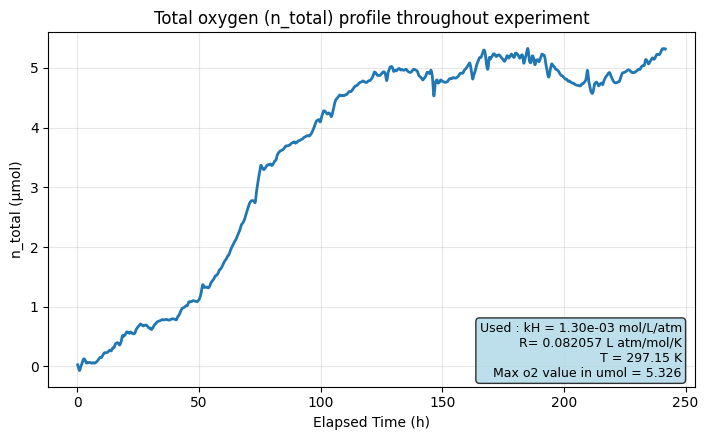

In [4]:
time_h     = pd.to_numeric(df[time_col])
p_kpa      = pd.to_numeric(df[press_col])
p_atm      = p_kpa / 101.325
n_gas_umol = pd.to_numeric(df[gas_col])

#constants
Vg = 0.002           # L
Vsol = 0.006         # L
T = 297.15  
KH = 1.3e-03
R = 0.082057



def calculate_n_total (p_atm: pd.Series, Vg: float, Vsol: float, R: float, T: float, KH: float) -> pd.Series:
    ntot = p_atm * ( (Vg / (R*T)) + (KH * Vsol)) 
    ntot_umol = ntot * 1e6  # Convert to µmol
    return ntot_umol


ntot_umol = calculate_n_total(p_atm, Vg, Vsol, R, T, KH)

print(ntot_umol.values.max())
df_out = pd.DataFrame({
    "Elapsed Time (h)": time_h,
    "n_total (µmol)": ntot_umol
})

plt.figure(figsize=(7.2, 4.5))
plt.plot(df_out["Elapsed Time (h)"], df_out["n_total (µmol)"], linewidth=2)
plt.ylabel("n_total (µmol)")
plt.xlabel("Elapsed Time (h)")
plt.title("Total oxygen (n_total) profile throughout experiment")

# Add detailed info box
info_text = f"""Used : kH = {KH:.2e} mol/L/atm
R= {R} L atm/mol/K
T = {T} K
Max o2 value in umol = {ntot_umol.values.max():.3f}"""

plt.text(0.98, 0.02, info_text, 
         transform=plt.gca().transAxes,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=9,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Same as above but instead of convertiung units to atm from kpa, keeping pressure units in Kpa

""" Units used:
K, kpa, mol, L, 
KH = 1.3 x 10^-3 mol / L / atm, 
R = 0.082057 L atm / K / mol, 
T = 297.15 K

5.325481163254313


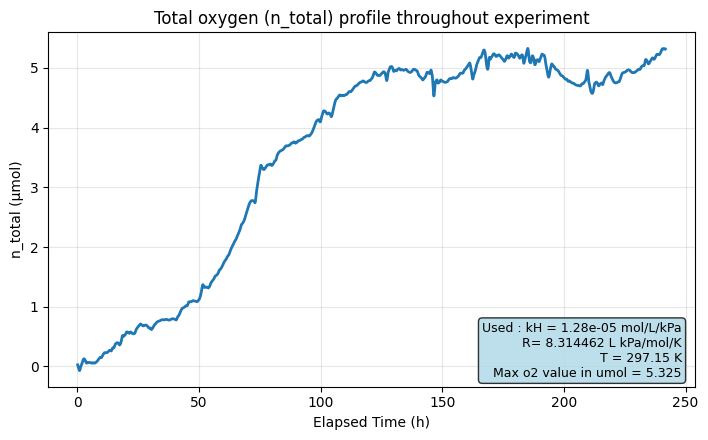

In [ ]:
time_h     = pd.to_numeric(df[time_col])
p_kpa      = pd.to_numeric(df[press_col])
n_gas_umol = pd.to_numeric(df[gas_col])

#constants
KH = 1.283e-5           # mol/L/kPa
Vsol = 0.006           # L
Vg = 0.002  
R = 8.314462           # L kPa/mol/K
T = 297.15             # K



def calculate_n_total (p_kpa: pd.Series, Vg: float, Vsol: float, R: float, T: float, KH: float) -> pd.Series:
    ntot = p_kpa * ( (Vg / (R*T)) + (KH * Vsol)) 
    ntot_umol = ntot * 1e6  # Convert to µmol
    return ntot_umol



ntot_umol = calculate_n_total(p_kpa, Vg, Vsol, R, T, KH)

print(ntot_umol.values.max())
df_out = pd.DataFrame({
    "Elapsed Time (h)": time_h,
    "n_total (µmol)": ntot_umol
})

plt.figure(figsize=(7.2, 4.5))
plt.plot(df_out["Elapsed Time (h)"], df_out["n_total (µmol)"], linewidth=2)
plt.ylabel("n_total (µmol)")
plt.xlabel("Elapsed Time (h)")
plt.title("Total oxygen (n_total) profile throughout experiment")

# Add detailed info box
info_text = f"""Used : kH = {KH:.2e} mol/L/kPa
R= {R} L kPa/mol/K
T = {T} K
Max o2 value in umol = {ntot_umol.values.max():.3f}"""

plt.text(0.98, 0.02, info_text, 
         transform=plt.gca().transAxes,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=9,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))




plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Using the full equation to see if there is a difference in the total umol produced by 1. keeping pressure and other units in Kpa   and 2. Keeping pressure and other units in atm




""" Units used:

KH = 1.283e-5          
R = 8.314462  


for atm,
KH = 1.3e-3                        
R=   0.082057366080960            


Sticking with K instead of C. The ideal gas law and henry's law both scale with kelvin so using celcius scaling will become inappropriate.


Using : Vg / (R * T) + kH * Vsol


"""

In [4]:
t_h   = pd.to_numeric(df[time_col], errors="coerce")
P_kPa = pd.to_numeric(df[press_col], errors="coerce")
mask = t_h.notna() & P_kPa.notna()
t_h, P_kPa = t_h[mask].reset_index(drop=True), P_kPa[mask].reset_index(drop=True)
t_h = t_h - t_h.iloc[0]  # start time at 0 h
P_atm = P_kPa / 101.325


# Geometry & constants
Vg   = 0.002     # L
Vsol = 0.006     # L
T_K  = 297.15    # K

# --- (A) kPa-guided calculation ---
R_kPa  = 8.31446261815324              # L·kPa·mol^-1·K^-1
kH_kPa = 1.3e-3 / 101.325              # mol·L^-1·kPa^-1 (~1.283e-5)
A_kPa  = Vg/(R_kPa*T_K) + kH_kPa*Vsol  # mol/kPa
n_tot_kPa_umol = P_kPa * A_kPa * 1e6   # µmol

# --- (B) atm-guided calculation ---
R_atm  = 0.082057366080960             # L·atm·mol^-1·K^-1
kH_atm = 1.3e-3                        # mol·L^-1·atm^-1
A_atm  = Vg/(R_atm*T_K) + kH_atm*Vsol  # mol/atm
n_tot_atm_umol = P_atm * A_atm * 1e6   # µmol

# Residuals
final_kpa = max(n_tot_kPa_umol)
final_atm = max(n_tot_atm_umol)
diff_umol = final_kpa - final_atm
print(f"max values of o2 in umol produced by keeping pressure in kpa : {final_kpa}")
print(f"max values of o2 in umol produced by keeping pressure in atm : {final_atm}")
print(f"Max |difference|: {np.abs(diff_umol):.6e} µmol")

max values of o2 in umol produced by keeping pressure in kpa : 5.325480890636497
max values of o2 in umol produced by keeping pressure in atm : 5.325480890636478
Max |difference|: 1.865175e-14 µmol


The above results because of Kpa vs atm just looks like rounding noise. There is no major difference in the total umol produced by both

### Vant hoff modelling for KH


Note that this is only applicable for O2 in water for temperatures less than 348K and delta H is in KJ / mol


1. The enthalpy values of different temperatures throughout the experiment cycle is noted down in the csv file :  M2_2.18mM_pressure_o2_release_DeltaH_from_T.csv

2. This is done so by using the fitting equation given in the paper by NIRST.

In [8]:
import pandas as pd
from pathlib import Path
import numpy as np

# ====== user inputs ======
csv_path  = "M2_2.18mM_pressure_o2_release.csv"
temp_col  = "calibrated temperature (C)"   # <-- exact column name in your file
# =========================

# Eq. (11) coefficients for O2 in water (<348 K)
A1, A2 =  83.91236, 23.24323
R = 8.314462618  # J·mol^-1·K^-1

def deltaH_J_per_mol(T_K: pd.Series) -> pd.Series:
    """
    ΔH°(T) = R * (A2*T - 100*A1)  [J/mol]
    (Since A3 = A4 = 0 for this temperature range.)
    """
    return R * (A2 * T_K - 100.0 * A1)

# --- load & clean ---
df = pd.read_csv(csv_path)
df.columns = [c.strip() for c in df.columns]
T_C_orig = pd.to_numeric(df[temp_col], errors="coerce").dropna().reset_index(drop=True)

# --- round °C to 2 decimals, convert to K ---
T_C_round2 = T_C_orig.round(2)
T_K_from_round = T_C_round2 + 273.15

# --- compute ΔH ---
dH_Jmol  = deltaH_J_per_mol(T_K_from_round)
dH_kJmol = dH_Jmol / 1000.0

# --- assemble output table ---
out = pd.DataFrame({
    "T_C_original": T_C_orig,
    "T_C_rounded_2dp": T_C_round2,
    "T_K_from_rounded": T_K_from_round,
    "DeltaH_kJ_per_mol": dH_kJmol
})

# --- save ---
out_path = Path(csv_path).with_name(Path(csv_path).stem + "_DeltaH_from_T.csv")
out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print(out.head(8).to_string(index=False))


Saved: M2_2.18mM_pressure_o2_release_DeltaH_from_T.csv
 T_C_original  T_C_rounded_2dp  T_K_from_rounded  DeltaH_kJ_per_mol
        24.31            24.31            297.46         -12.282996
        24.32            24.32            297.47         -12.281063
        24.31            24.31            297.46         -12.282996
        24.30            24.30            297.45         -12.284928
        24.33            24.33            297.48         -12.279130
        24.32            24.32            297.47         -12.281063
        24.31            24.31            297.46         -12.282996
        24.32            24.32            297.47         -12.281063


Now actually finding the different henry's constant values with the different H values.

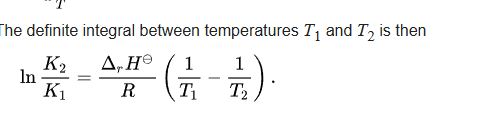

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path

# ===== inputs =====
# CSV produced in the previous step (with T_K_from_rounded + DeltaH_kJ_per_mol)
dh_csv_path = "M2_2.18mM_pressure_o2_release_DeltaH_from_T.csv"
tempK_col   = "T_K_from_rounded"      # Kelvin (from rounded °C)
dH_col      = "DeltaH_kJ_per_mol"     # kJ/mol
# Reference (always relative to this):
T_REF_K     = 297.15                  # K
kH_ref_atm  = 1.30e-3                 # mol·L^-1·atm^-1 at 297.15 K
R_J         = 8.314462618             # J·mol^-1·K^-1
# ==================

# Load ΔH data
df = pd.read_csv(dh_csv_path)
TK = pd.to_numeric(df[tempK_col], errors="coerce")
dH_kJmol = pd.to_numeric(df[dH_col], errors="coerce")

# van’t Hoff: kH(T) = kH_ref * exp( -(ΔH/R)*(1/T - 1/T_ref) )
dH_Jmol = dH_kJmol * 1000.0
ln_ratio = -dH_Jmol / R_J * (1.0/TK - 1.0/T_REF_K)
kH_T_atm = kH_ref_atm * np.exp(ln_ratio)   # mol·L^-1·atm^-1

# Build output table
out = pd.DataFrame({
    "Temperature_K": TK,
    "DeltaH_kJ_per_mol": dH_kJmol,
    "kH_mol_per_L_atm": kH_T_atm
})

# Save
out_path = Path("henry's constants.csv")
out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print(out.head().to_string(index=False))




Saved: henry's constants.csv
 Temperature_K  DeltaH_kJ_per_mol  kH_mol_per_L_atm
        297.46         -12.282996          0.001293
        297.47         -12.281063          0.001293
        297.46         -12.282996          0.001293
        297.45         -12.284928          0.001293
        297.48         -12.279130          0.001293


Now using the generated Henry's constant value for each temperature on the whole equation:

Saved: M2_2.18mM_pressure_o2_release_n_total_dynamic_T_kH.csv
5.311087176954677


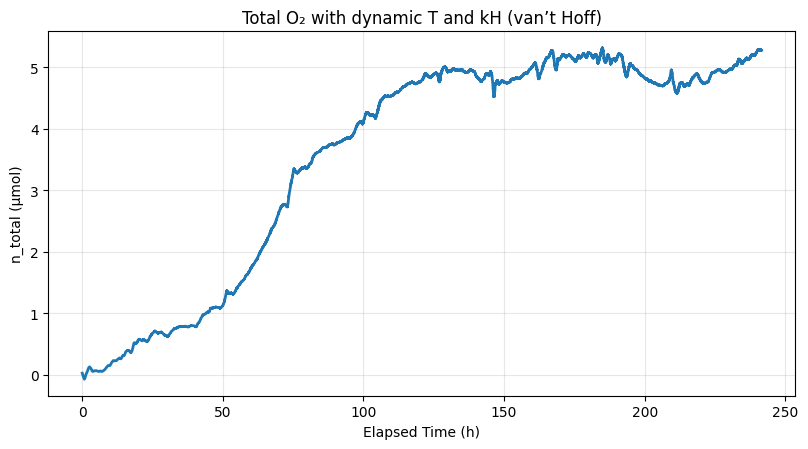

In [15]:

henry_csv  = r"C:\Users\chand\Documents\GitHub\Thesis\henry's constants.csv"



# Constants (atm-based calc)
R   = 0.082057366079   # L·atm·mol^-1·K^-1
Vg  = 0.002            # L
Vsol= 0.006            # L


t_h   = pd.to_numeric(df[time_col])
P_kPa = pd.to_numeric(df[press_col])
mask  = t_h.notna() & P_kPa.notna()
t_h, P_kPa = t_h[mask].reset_index(drop=True), P_kPa[mask].reset_index(drop=True)
t_h = t_h - t_h.iloc[0]  # start time at 0 h

# Absolute pressure in atm

P_atm = P_kPa / 101.325

# Henry/Temperature (dynamic) from file
hdf = pd.read_csv(henry_csv)
hdf.columns = [c.strip() for c in hdf.columns]
T_K  = pd.to_numeric(hdf["Temperature_K"])
kH_T = pd.to_numeric(hdf["kH_mol_per_L_atm"])


# --- compute n_total(t) in µmol with dynamic T and kH ---
A_gas_term = Vg / (R * T_K.values)          # mol/atm
A_aq_term  = kH_T.values * Vsol             # mol/atm
A_total    = A_gas_term + A_aq_term         # mol/atm

n_tot_umol = (P_atm.values * A_total) * 1e6  # µmol

out = pd.DataFrame({
    "Elapsed Time (h)": t_h,
    "P_abs (atm)": P_atm,
    "Temperature_K": T_K,
    "kH_mol_per_L_atm": kH_T,
    "n_tot (µmol)": n_tot_umol
})
out_path = Path(csv_path).with_name(Path(csv_path).stem + "_n_total_dynamic_T_kH.csv")
out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")


print(max(n_tot_umol))
# --- quick plot ---
plt.figure(figsize=(8.2, 4.6))
plt.plot(out["Elapsed Time (h)"], out["n_tot (µmol)"], linewidth=2)
plt.xlabel("Elapsed Time (h)")
plt.ylabel("n_total (µmol)")
plt.title("Total O₂ with dynamic T and kH (van’t Hoff)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Saved: M2_2.18mM_pressure_o2_release_n_total_const_vs_dynamic.csv


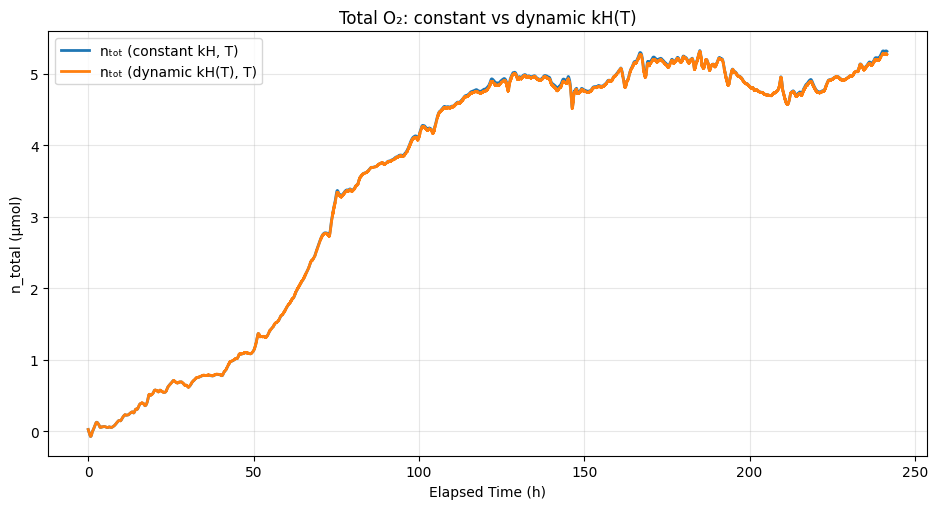

<Figure size 640x480 with 0 Axes>


=== End-of-run totals (tail median) ===
Constant: 5.319517 µmol
Dynamic : 5.276372 µmol
Δ Final : -0.043145 µmol (-0.8111 % of constant)


In [18]:

henry_csv  = "henry's constants.csv"         # must align row-wise with main_csv


# Constants (atm system)
R_atm  = 0.082057366079   # L·atm·mol^-1·K^-1
Vg     = 0.002            # L
Vsol   = 0.006            # L
KH_const = 1.3e-3         # mol·L^-1·atm^-1 (constant case)
T_const  = 297.15         # K (constant case)
KPA_PER_ATM = 101.325

# ---------- load main ----------
df = pd.read_csv(main_csv)
df.columns = [c.strip() for c in df.columns]
time_h = pd.to_numeric(df[time_col], errors="coerce")
P_kPa  = pd.to_numeric(df[press_col], errors="coerce")
mask   = time_h.notna() & P_kPa.notna()
time_h, P_kPa = time_h[mask].reset_index(drop=True), P_kPa[mask].reset_index(drop=True)
time_h = time_h - time_h.iloc[0]  # start at 0 h

# Absolute pressure (atm)

P_atm= P_kPa / KPA_PER_ATM

# ---------- load Henry (dynamic) ----------
hdf = pd.read_csv(henry_csv)
hdf.columns = [c.strip() for c in hdf.columns]
T_K_dyn  = pd.to_numeric(hdf["Temperature_K"], errors="coerce")
kH_dyn   = pd.to_numeric(hdf["kH_mol_per_L_atm"], errors="coerce")

if len(T_K_dyn) != len(P_abs_atm):
    raise ValueError(f"Row mismatch: main={len(P_abs_atm)}, henry={len(T_K_dyn)}. "
                     "Regenerate Henry file from the same filtered rows so they align 1:1.")

# ---------- n_tot (constant kH, T) ----------
A_const = Vg/(R_atm*T_const) + KH_const*Vsol   # mol/atm
n_tot_const_umol = (P_atm* A_const) * 1e6

# ---------- n_tot (dynamic kH(T), T) ----------
A_dyn = Vg/(R_atm*T_K_dyn.values) + kH_dyn.values*Vsol  # mol/atm
n_tot_dyn_umol = (P_atm.values * A_dyn) * 1e6

# ---------- differences ----------
diff_umol = n_tot_dyn_umol - n_tot_const_umol
pct_diff  = 100.0 * diff_umol / np.maximum(np.abs(n_tot_const_umol), 1e-12)

# ---------- save comparison CSV ----------
out = pd.DataFrame({
    "Elapsed Time (h)": time_h,
    "P_abs (atm)": P_atm,
    "T_K_dynamic": T_K_dyn,
    "kH_dynamic (mol/L/atm)": kH_dyn,
    "n_tot_const (µmol)": n_tot_const_umol,
    "n_tot_dynamic (µmol)": n_tot_dyn_umol,
    "diff_dynamic_minus_const (µmol)": diff_umol,
    "diff_percent_of_const (%)": pct_diff
})
out_path = Path(csv_path).with_name(Path(csv_path).stem + "_n_total_const_vs_dynamic.csv")
out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

# ---------- PLOTS ----------
# (1) Overlay with shaded difference
plt.figure(figsize=(9.5, 5.2))
plt.plot(time_h, n_tot_const_umol, linewidth=2, label="nₜₒₜ (constant kH, T)")
plt.plot(time_h, n_tot_dyn_umol, linewidth=2, label="nₜₒₜ (dynamic kH(T), T)")
# shade where dynamic > constant (above), and constant > dynamic (below)
above = n_tot_dyn_umol >= n_tot_const_umol

plt.xlabel("Elapsed Time (h)")
plt.ylabel("n_total (µmol)")
plt.title("Total O₂: constant vs dynamic kH(T)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

# (3) Optional: quick summary numbers
tail = max(5, len(time_h)//200)  # ~0.5% tail median to reduce last-point noise
final_const = float(np.median(n_tot_const_umol[-tail:]))
final_dyn   = float(np.median(n_tot_dyn_umol[-tail:]))
print("\n=== End-of-run totals (tail median) ===")
print(f"Constant: {final_const:.6f} µmol")
print(f"Dynamic : {final_dyn:.6f} µmol")
print(f"Δ Final : {final_dyn - final_const:.6f} µmol "
      f"({100*(final_dyn-final_const)/max(final_const,1e-12):.4f} % of constant)")


The dynamic correction barely moves the needle

# Using vanthoff again in KJ instead of J for enthalpy and R




In [19]:
import pandas as pd
import numpy as np
from pathlib import Path

# ==== inputs (adjust path if needed) ====
enthalpy_csv_path = "M2_2.18mM_pressure_o2_release_DeltaH_from_T.csv"
T_ref = 297.15                 # K (reference temperature)
kH_ref = 1.30e-3               # mol·L^-1·atm^-1 at T_ref
R_kJ = 0.008314462618          # kJ·mol^-1·K^-1  (so ΔH can stay in kJ/mol)
# =======================================

df = pd.read_csv(enthalpy_csv_path)

# Pull T (K) and ΔH (kJ/mol)
T_K = df["T_K_from_rounded"].astype(float)
dH_kJmol = df["DeltaH_kJ_per_mol"].astype(float)

# van’t Hoff: ln(K2/K1) = (ΔH/R) * (1/T1 - 1/T2)
# Here: K(T) = kH_ref * exp( (ΔH/R) * (1/T_ref - 1/T) )
expo = (dH_kJmol / R_kJ) * (1.0 / T_ref - 1.0 / T_K)
kH_T = kH_ref * np.exp(expo)   # mol·L^-1·atm^-1

# Build and save output
out = pd.DataFrame({
    "T_K": T_K,
    "DeltaH_kJ_per_mol": dH_kJmol,
    "kH_mol_per_L_atm": kH_T
})

out_path = Path("henry's constants_2.csv")
out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print(out.head(8).to_string(index=False))


Saved: henry's constants_2.csv
   T_K  DeltaH_kJ_per_mol  kH_mol_per_L_atm
297.46         -12.282996          0.001293
297.47         -12.281063          0.001293
297.46         -12.282996          0.001293
297.45         -12.284928          0.001293
297.48         -12.279130          0.001293
297.47         -12.281063          0.001293
297.46         -12.282996          0.001293
297.47         -12.281063          0.001293


# use this henry's constant value with different T values to calculate ntot




Saved: M2_2.18mM_pressure_o2_release_ntot_dynamic_T_kH_in KJ.csv
5.311087201384232


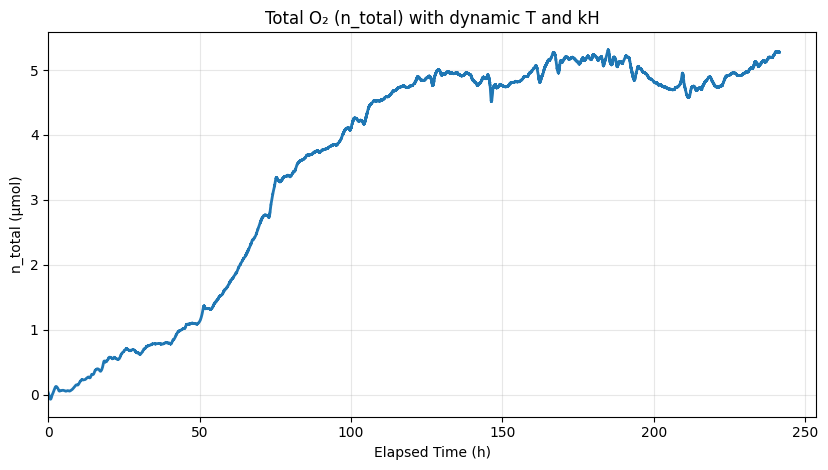

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------- inputs --------
main_csv_path   = "M2_2.18mM_pressure_o2_release.csv"
henry_csv_path  = "henry's constants_2.csv"   # from your previous step
time_col        = "Time (s)"                # your time column (already in hours)
press_col       = "DWT denoised pressure (kPa)"  # PO2 or total; 

# ------------------------

# Constants (atm formulation)
R = 0.08205736608096   # L·atm·mol^-1·K^-1
Vg = 0.002             # L (headspace)
Vsol = 0.006           # L (solution)
ATM_KPA = 101.325

# --- load data ---
df = pd.read_csv(main_csv_path)
df.columns = [c.strip() for c in df.columns]
hen = pd.read_csv(henry_csv_path)
hen.columns = [c.strip() for c in hen.columns]

# Pull needed series
t_h   = pd.to_numeric(df[time_col], errors="coerce")
P_kPa = pd.to_numeric(df[press_col], errors="coerce")
T_K   = pd.to_numeric(hen["T_K"], errors="coerce")
kH_T  = pd.to_numeric(hen["kH_mol_per_L_atm"], errors="coerce")

# Align lengths (assumes both files were derived row-wise from same run)
n = min(len(t_h), len(P_kPa), len(T_K), len(kH_T))
t_h   = t_h.iloc[:n].reset_index(drop=True)
P_kPa = P_kPa.iloc[:n].reset_index(drop=True)
T_K   = T_K.iloc[:n].reset_index(drop=True)
kH_T  = kH_T.iloc[:n].reset_index(drop=True)

# Absolute pressure in atm

P_abs_atm = P_kPa / ATM_KPA

# --- compute n_total(t) in µmol with dynamic T and kH ---
A_gas_term = Vg / (R * T_K.values)     # mol/atm
A_aq_term  = kH_T.values * Vsol        # mol/atm
A_total    = A_gas_term + A_aq_term    # mol/atm

n_tot_umol = P_abs_atm.values * A_total * 1e6  # µmol

# --- save results ---
out = pd.DataFrame({
    "Elapsed Time (h)": t_h - t_h.iloc[0],
    "T_K": T_K,
    "kH_mol_per_L_atm": kH_T,
    "A_gas_term (mol/atm)": A_gas_term,
    "A_aq_term (mol/atm)": A_aq_term,
    "n_total (µmol)": n_tot_umol
})
out_path = Path(main_csv_path).with_name(Path(main_csv_path).stem + "_ntot_dynamic_T_kH_in KJ.csv")
out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print(max(n_tot_umol))
# --- quick plot ---
plt.figure(figsize=(8.4, 4.8))
plt.plot(out["Elapsed Time (h)"], out["n_total (µmol)"], linewidth=2)
plt.xlabel("Elapsed Time (h)")
plt.ylabel("n_total (µmol)")
plt.title("Total O₂ (n_total) with dynamic T and kH")
plt.grid(True, alpha=0.3)
plt.xlim(left=0)
plt.tight_layout()
plt.show()


### KK modelling for KH


take Henry's constant at 1 atm, 25°C H0 = 769
Because the K–K function is written for the “volatility” form of Henry’s constant,(the first one in the table)(source wikipedia: https://en.wikipedia.org/wiki/Henry's_law)

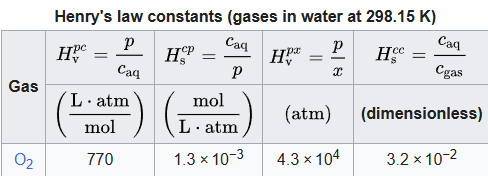

In [1]:




import pandas as pd
import numpy as np
from pathlib import Path

# -------- inputs --------
main_csv_path  = "M2_2.18mM_pressure_o2_release.csv"
henry_csv_path = "henry's constants_2.csv"     # must contain a column 'T_K'
press_col      = "DWT denoised pressure (kPa)" # PO2 in kPa (absolute)
time_col       = "Time (s)"                    # already in hours in your file
# -----------------------

# --- load data ---
df  = pd.read_csv(main_csv_path)
hen = pd.read_csv(henry_csv_path)

# --- prepare series (align lengths if needed) ---
p_kpa = pd.to_numeric(df[press_col], errors="coerce")
p_atm = p_kpa / 101.325
T_K   = pd.to_numeric(hen["T_K"], errors="coerce")

n = min(len(p_atm), len(T_K))
p_atm = p_atm.iloc[:n].reset_index(drop=True)
T_K   = T_K.iloc[:n].reset_index(drop=True)



# --- Krichevsky–Kasarnovsky (keep logic EXACTLY as provided) ---
def henry_krichevsky_kasarnovsky(P_atm, T_kelvin):
    # Reference Henry's constant at 1 atm, 25°C
    H0 = 770  # atm·L/mol

    # Partial molar volume of O2 in water at infinite dilution
    V_infinity = 32e-6  # m3/mol (literature value for O2 in water)

    # Gas constant
    R = 8.31446261815324
    P0_atm = 1.0  # Reference pressure

    # Convert pressures to Pa
    P_pa = P_atm * 101325
    P0_pa = P0_atm * 101325

    # Krichevsky-Kasarnovsky equation
    ln_H = np.log(H0) + (V_infinity * (P_pa - P0_pa)) / (R * T_kelvin)
    H = np.exp(ln_H)

    return H

# --- compute H for each row ---
H_atmL_per_mol = henry_krichevsky_kasarnovsky(p_atm, T_K)

# --- save to CSV ---
out = pd.DataFrame({
    "Elapsed Time (h)": t_h,                 # will be NaN if time_col not present
    "P_atm": p_atm,
    "T_K": T_K,
    "H_atmL_per_mol": H_atmL_per_mol
})
out_path = Path("KK_Hvalues.csv")
out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print(out.head().to_string(index=False))


NameError: name 't_h' is not defined

Saved: ntot_from_KK_H.csv
5.315783667342482


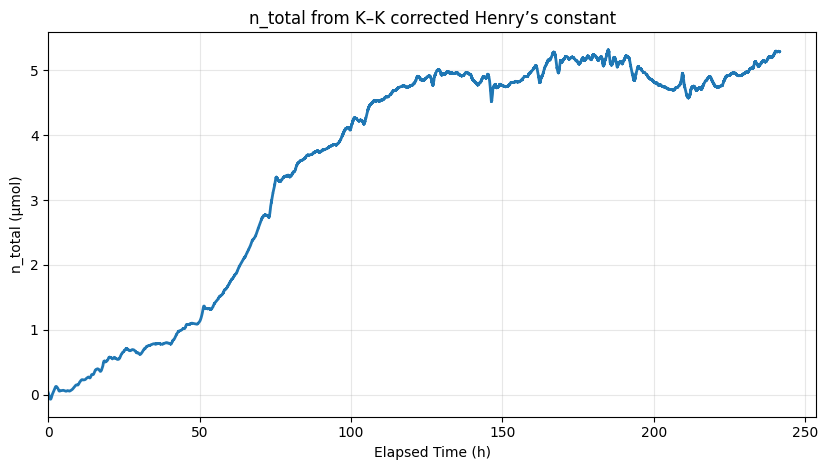

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------- inputs --------
main_csv_path  = "M2_2.18mM_pressure_o2_release.csv"
press_col      = "DWT denoised pressure (kPa)"   # absolute kPa for the gas you care about
time_col       = "Time (s)"                      # already hours
KK_H_csv       = "KK_Hvalues.csv"                # has columns: P_atm, T_K, H_atmL_per_mol

# ------------------------

# constants (atm, L, mol, K system)
R   = 0.08205736608096     # L·atm·mol^-1·K^-1
Vg  = 0.002                # L
Vsol= 0.006                # L
ATM_KPA = 101.325

# --- load data ---
df_main = pd.read_csv(main_csv_path)
df_main.columns = [c.strip() for c in df_main.columns]
df_H    = pd.read_csv(KK_H_csv)
df_H.columns = [c.strip() for c in df_H.columns]

# pull series and align
t_h   = pd.to_numeric(df_main[time_col], errors="coerce")
P_kPa = pd.to_numeric(df_main[press_col], errors="coerce")
T_K   = pd.to_numeric(df_H["T_K"], errors="coerce")
H     = pd.to_numeric(df_H["H_atmL_per_mol"], errors="coerce")   # atm·L/mol from K–K

n = min(len(t_h), len(P_kPa), len(T_K), len(H))
t_h, P_kPa, T_K, H = [s.iloc[:n].reset_index(drop=True) for s in (t_h, P_kPa, T_K, H)]
t_h = t_h - t_h.iloc[0]  # start at 0 h

# absolute pressure (atm)

P_abs_atm = P_kPa / ATM_KPA

# convert H -> kH
kH = 1.0 / H  # mol·L^-1·atm^-1

# --- n_total(t) in µmol with dynamic T and kH(H from K–K) ---
A_gas_term = Vg / (R * T_K.values)   # mol/atm
A_aq_term  = kH.values * Vsol        # mol/atm
A_total    = A_gas_term + A_aq_term  # mol/atm
n_tot_umol = (P_abs_atm.values * A_total) * 1e6

# save
out = pd.DataFrame({
    "Elapsed Time (h)": t_h,
    "P_abs (atm)": P_abs_atm,
    "T_K": T_K,
    "H_atmL_per_mol": H,
    "kH_mol_per_L_atm": kH,
    "n_total (µmol)": n_tot_umol
})
out_path = Path("ntot_from_KK_H.csv")
out.to_csv(out_path, index=False)
print(f"Saved: {out_path}")
print(max(n_tot_umol))

# plot
plt.figure(figsize=(8.4, 4.8))
plt.plot(out["Elapsed Time (h)"], out["n_total (µmol)"], lw=2)
plt.xlabel("Elapsed Time (h)")
plt.ylabel("n_total (µmol)")
plt.title("n_total from K–K corrected Henry’s constant")
plt.grid(True, alpha=0.3)
plt.xlim(left=0)
plt.tight_layout()
plt.show()


  # Optimizing headspace to volume ratio based on findings to get better detection efficiency by the sensor at headspace:

Assuming changing Vg: Vsol only changes the way gas partitions into the liquid and into the headspace. with this asumption, for any concentration, the ntot ideally should remain the same while only the gas redistributes into head or dissolved phase.


What are the cases this could be debubnked with?

General talks about detection efficiency:
It is the equilibrium partitioning between gas and liquid set by geometry + Henry’s law (irrespective of how much was produced(either 5.29umol or 13.08umol)):